# 7. 指令遵循微调

本章涵盖以下内容：

+ **LLM 指令微调过程概述**
+ **为监督式指令微调准备数据集**
+ **批量组织指令数据**
+ **评估 LLM 通过指令遵循生成的内容质量**
+ **评估一个经过指令微调的 LLM**

-----

- [7.1 指令遵循微调简介](#71-指令遵循微调简介)
- [7.2 为监督指令微调准备数据集](#72-为监督指令微调准备数据集)
- [7.3 将数据组织成训练批次](#73-将数据组织成训练批次)
- [7.4 为指令数据集创建数据加载器](#74-为指令数据集创建数据加载器)
- [7.5 加载预训练的 LLM](#75-加载预训练的-llm)
- [7.6 指令微调 LLM](#76-指令微调-llm)
- [7.7 提取并保存响应](#77-提取并保存响应)
- [7.8 评估指令微调后的 LLM](#78-评估指令微调后的-llm)
- [7.9 结语](#79-结语)
  - [7.9.1 接下来如何做？](#791-接下来如何做)
  - [7.9.2 如何在快速变化的前沿领域中保持领先](#792-如何在快速变化的前沿领域中保持领先)
- [7.10 本章摘要](#710-本章摘要)


-----



在之前的章节中，我们实现了 LLM 架构，完成了预训练，并将外部的预训练权重导入模型。接着，在上一章中，我们专注于对 LLM 进行特定分类任务的微调，即区分出正常短信和垃圾短信。在本章中，我们将介绍如何微调 LLM 以遵循人类指令（见图 7.1），这是开发用于聊天机器人、个人助理和其他对话任务的 LLM 的主要技术之一。

<img src="../Image/chapter7/figure7.1.png" width="75%" />

图 7.1 展示了微调 LLM 的两种主要方式：用于分类任务的微调（步骤 8）和用于指令遵循的微调（步骤 9）。上一章中我们已实现了步骤 8，本章将重点讲解如何使用指令数据集微调 LLM，具体过程将在下一节进一步说明。



## 7.1 指令遵循微调简介

我们在第 5 章中已了解到对 LLM 的预训练是一种逐词生成的学习过程。预训练后，LLM 将具备根据输入片段补全文本的能力，可以完成句子或生成段落。

然而，预训练的 LLM 在处理如“修正该文本的语法”或“将该文本转换为被动语态”等特定指令时往往表现不佳。我们将在第 7.5 节中详细讨论一个具体示例，演示如何加载预训练模型并基于其进行指令微调。

本章将专注于提升 LLM 遵循指令并生成理想回答的能力，如图 7.2 所示。

<img src="../Image/chapter7/figure7.2.png" width="75%" />

在本章的剩余部分，我们将逐步实现指令微调过程，首先从数据集准备开始，如图 7.3 所示。

<img src="../Image/chapter7/figure7.3.png" width="75%" />

数据集准备是指令微调中的关键环节，本章的大部分内容都将围绕这一过程展开。下一节将开始实现下载和格式化数据集的代码，这是数据集准备过程的第一步（如图 7.3 所示）。

---

## 7.2 为监督指令微调准备数据集

在本节中，我们将下载并格式化指令数据集，以便对预训练的 LLM 进行指令微调。该数据集包含 1100 组指令-响应对，类似于图 7.2 中所示的示例。该数据集专为本书创建，有兴趣的读者可以在附录 B 中找到其他公开的指令数据集。

以下代码通过实现并执行一个函数来下载这个数据集。该数据集体积较小（仅 204 KB），采用 JSON 格式，其结构与 Python 字典类似，便于人类阅读和机器处理。

In [2]:
# Listing 7.1 Downloading the dataset
import json
import os
import urllib

def download_and_load_file(file_path, url):
    if not os.path.exists(file_path):
        with urllib.request.urlopen(url) as response:
            text_data = response.read().decode("utf-8")
        with open(file_path, "w", encoding="utf-8") as file:
            file.write(text_data)
    else: #A
        with open(file_path, "r", encoding="utf-8") as file:
            text_data = file.read()
    with open(file_path, "r") as file:
        data = json.load(file)
    return data

file_path = "../data/instruction-data.json"
url = "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch/main/ch07/01_mainchapter-code/instruction-data.json"

data = download_and_load_file(file_path, url)
print("Number of entries:", len(data))

Number of entries: 1100


可以看到，我们从 JSON 文件中加载的‘数据列表’包含 1100 条指令数据集记录。让我们打印其中一条记录，看看每条记录的结构：

In [3]:
print("Example entry:\n", data[50])

Example entry:
 {'instruction': 'Identify the correct spelling of the following word.', 'input': 'Ocassion', 'output': "The correct spelling is 'Occasion.'"}


如我们所见，打印出的记录是一个包含 'instruction'、'input' 和 'output' 键值的 Python 字典对象。我们来看另一条记录：


根据该记录的内容，‘input’ 字段可能偶尔为空。

In [4]:
print("Another example entry:\n", data[999])

Another example entry:
 {'instruction': "What is an antonym of 'complicated'?", 'input': '', 'output': "An antonym of 'complicated' is 'simple'."}


指令微调（instruction finetuning），也称为监督式指令微调（supervised instruction finetuning），是指在包含明确输入-输出对的数据集上对模型进行训练（例如从 JSON 文件中提取的输入-输出对）。在为大语言模型（LLM）格式化这些条目时，通常会使用多种不同的方法。图 7.4 展示了两种不同的示例格式（通常称为提示风格），这些格式常用于训练一些知名的 LLM，例如 Alpaca 和 Phi-3。Alpaca 是最早公开指令微调过程的 LLM 之一，而由微软开发的 Phi-3 则展示了提示风格的多样性。

<img src="../Image/chapter7/figure7.4.png" width="75%" />

本章其余部分将使用 Alpaca 风格的提示方式，这是最受欢迎的提示风格之一，主要是因为它帮助定义了最初的微调方法。

> **练习 7.1 改变提示词风格**
>
> 在使用 Alpaca 提示语风格对模型进行微调之后，尝试图 7.4 中展示的 Phi-3 提示语风格，并观察其是否会影响模型的响应效果。

我们首先定义一个`format_input`函数，用于将数据列表中的条目转换为如图 7.4 所示的 Alpaca 风格输入格式：

In [5]:
# Listing 7.2 Implementing the prompt formatting function
def format_input(entry):
    instruction_text = (
        f"Below is an instruction that describes a task. "
        f"Write a response that appropriately completes the request."
        f"\n\n### Instruction:\n{entry['instruction']}"
    )
    input_text = f"\n\n### Input:\n{entry['input']}" if entry["input"] else ""
    return instruction_text + input_text

`format_input` 函数接受一个字典条目作为输入，并构建格式化字符串。我们来用之前查看过的数据集条目 `data[50]` 测试一下这个函数的效果：

In [6]:
model_input = format_input(data[50])
desired_response = f"\n\n### Response:\n{data[50]['output']}"
print(model_input + desired_response)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Identify the correct spelling of the following word.

### Input:
Ocassion

### Response:
The correct spelling is 'Occasion.'


请注意，当 'input' 字段为空时，`format_input`函数会跳过可选的 '### Input:' 部分。我们可以通过将`format_input`函数应用于之前检查过的数据项 data[999] 来测试这一点：

In [7]:
model_input = format_input(data[999])
desired_response = f"\n\n### Response:\n{data[999]['output']}"
print(model_input + desired_response)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
What is an antonym of 'complicated'?

### Response:
An antonym of 'complicated' is 'simple'.


在进入下一节的 PyTorch 数据加载器设置之前，先将数据集划分为训练集、验证集和测试集，这与我们在上一章处理垃圾短信分类数据集时的划分方式类似。下面是具体的划分比例计算方式：

In [8]:
# Listing 7.3 Partitioning the dataset
train_portion = int(len(data) * 0.85) # 85% for training
test_portion = int(len(data) * 0.1) # 10% for testing
val_portion = len(data) - train_portion - test_portion # Remaining 5% for validation

train_data = data[:train_portion]
test_data = data[train_portion:train_portion + test_portion]
val_data = data[train_portion + test_portion:]

print("Training set length:", len(train_data))
print("Validation set length:", len(val_data))
print("Test set length:", len(test_data))

Training set length: 935
Validation set length: 55
Test set length: 110


在成功下载并划分数据集，同时清晰地理解了数据集的提示格式后，我们现在准备开始指令微调过程的核心实现。在接下来的部分中，我们将重点讨论如何构建用于微调 LLM 的训练批次。

---

## 7.3 将数据组织成训练批次

随着我们进入指令微调过程的实施阶段，接下来的步骤（如图 7.5 所示）将重点介绍如何高效地构建训练批次。这一步需要定义一种方法，以确保模型在微调过程中能够接收到格式化的训练数据。

<img src="../Image/chapter7/figure7.5.png" width="75%" />

在上一章中，训练批次是通过 PyTorch 的 `DataLoader` 类自动创建的，该类使用默认的`collate`函数将样本列表合并为批次。`collate` 函数的作用是将单个数据样本列表合并成一个批次，以便模型在训练过程中能够高效处理。

然而，为了适应指令微调的需求，本章的批处理过程更为复杂，需要我们创建一个自定义的 collate 函数，并将其嵌入到 `DataLoader` 中，以便处理指令微调数据集的特定需求和格式。

本节将分几步介绍批处理过程（包括自定义`collate`函数的编写），具体内容如图 7.6 所示。

<img src="../Image/chapter7/figure7.6.png" width="75%" />

首先，为实现图 7.6 中展示的步骤 2.1 和 2.2，我们编写了一个 `InstructionDataset` 类，它应用了上一节中的 `format_input` 函数，并对数据集中的所有输入进行了预分词，类似于第 6 章中的 `SpamDataset`。这两个步骤的详细说明见图 7.7。

<img src="../Image/chapter7/figure7.7.png" width="75%" />

图 7.7 中展示的 两步操作通过 `InstructionDataset` 类的 `__init__` 构造函数实现。

In [9]:
# Listing 7.4 Implementing an instruction dataset class
import torch
from torch.utils.data import Dataset

class InstructionDataset(Dataset):
    def __init__(self, data, tokenizer):
        self.data = data
        self.encoded_texts = []
        for entry in data:  # 预分词文本
            instruction_plus_input = format_input(entry)
            response_text = f"\n\n### Response:\n{entry['output']}"
            full_text = instruction_plus_input + response_text
            self.encoded_texts.append(
                tokenizer.encode(full_text)
            )

    def __getitem__(self, index):
        return self.encoded_texts[index]

    def __len__(self):
        return len(self.data)

与第 6 章的方法类似，我们通过将多个训练样本收集到一个批次中来加速训练，这需要将所有输入填充到相似的长度。对此，我们使用与前一章一样的 `<|endoftext|>` 作为填充标记。

我们可以直接将 `<|endoftext|>` token 的 token ID 追加到预处理后的输入中，而不是将 `<|endoftext|>` token 本身追加到文本输入中。为了明确应该使用哪个 token ID，我们可以对 `<|endoftext|>` token 使用分词器的 `.encode` 方法：

In [10]:
import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")
print(tokenizer.encode("<|endoftext|>", allowed_special={"<|endoftext|>"}))

[50256]


在第 6 章中，我们使用的填充方式是将数据集中的所有示例填充到相同长度。在本章中，我们将采用一种更为精细的方法，开发一个自定义的`collate`函数并传递给数据加载器。该自定义`collate`函数会将每个批次中的训练样本填充到相同长度，同时允许不同批次中的样本具有不同的长度，如图 7.8 所示。这种方法通过仅将序列扩展到每个批次中最长的序列长度，从而减少了不必要的填充，避免了对整个数据集进行冗余填充。

<img src="../Image/chapter7/figure7.8.png" width="75%" />

我们可以通过以下自定义`collate`函数来实现图 7.8 所示的填充过程：

In [11]:
def custom_collate_draft_1(
    batch,
    pad_token_id=50256,
    device="cpu"
):
    # 找出批量中的最长序列
    batch_max_length = max(len(item)+1 for item in batch)
    inputs_lst = []

    # 对输入进行填充并准备好输入数据
    for item in batch:
        new_item = item.copy()
        new_item += [pad_token_id]

        padded = new_item + [pad_token_id] * (batch_max_length - len(new_item))

        # 删除之前添加的多余填充 token
        inputs = torch.tensor(padded[:-1])
        inputs_lst.append(inputs)

    inputs_tensor = torch.stack(inputs_lst).to(device)             #D
    return inputs_tensor

我们实现的 `custom_collate_draft_1` 虽然设计用于集成到 PyTorch 的 DataLoader 中，但它也可以独立使用。在这里，我们单独使用它来测试和验证其功能是否符合预期。我们将在三个不同输入上进行测试，目标是将它们合并为一个批次，并对每个样本进行填充以保证长度一致：

In [12]:
inputs_1 = [0, 1, 2, 3, 4]
inputs_2 = [5, 6]
inputs_3 = [7, 8, 9]
batch = (
    inputs_1,
    inputs_2,
    inputs_3
)
print(custom_collate_draft_1(batch))

tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])


如输出所示，所有输入序列都已被填充到最长输入序列的长度，其中`inputs_1`包含了 5 个 token ID。

我们刚刚实现了自定义 `collate` 函数的第一个版本，用于从输入列表创建批次。然而，正如在第 5 章和第 6 章中所学的那样，我们还需要创建与输入 ID 批次相对应的目标 token ID 批次。图 7.9 显示了这些目标 ID，它们非常重要，因为它们代表我们希望模型生成的内容，并且在训练时用于计算损失，从而指导模型更新权重。这与之前章节的做法类似。

<img src="../Image/chapter7/figure7.9.png" width="75%" />

如图 7.9 所示，我们需要修改自定义的`collate`函数，使其在返回输入 token ID 的基础上，同时返回目标 token ID。

与第 5 章中描述的 LLM 预训练过程类似，目标 token ID 与输入 token ID 一一对应，但会右移一个位置，这种设置（如图 7.10 所示）使得 LLM 能够学习如何预测序列中的下一个 token。

<img src="../Image/chapter7/figure7.10.png" width="75%" />

以下为更新后的`collate`函数，它根据输入 token ID 生成目标 token ID（流程如图 7.10 所示）：

In [13]:
def custom_collate_draft_2(
    batch,
    pad_token_id=50256,
    device="cpu"
):
    batch_max_length = max(len(item)+1 for item in batch)
    inputs_lst, targets_lst = [], []

    for item in batch:
        new_item = item.copy()
        new_item += [pad_token_id]
        padded = new_item + [pad_token_id] * (batch_max_length - len(new_item))
        inputs = torch.tensor(padded[:-1])             #A
        targets = torch.tensor(padded[1:])             #B
        inputs_lst.append(inputs)
        targets_lst.append(targets)

    inputs_tensor = torch.stack(inputs_lst).to(device)
    targets_tensor = torch.stack(targets_lst).to(device)
    return inputs_tensor, targets_tensor

inputs, targets = custom_collate_draft_2(batch)
print(inputs)
print(targets)


#A 截断输入序列的最后一个 token。
#B 将目标序列中的每个 token 向右移动一个位置。

tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])
tensor([[    1,     2,     3,     4, 50256],
        [    6, 50256, 50256, 50256, 50256],
        [    8,     9, 50256, 50256, 50256]])


对于之前定义的包含 3 个输入列表的示例批次，更新后的`custom_collate_draft_2`函数会返回输入和目标批次数据。

在接下来的步骤中，我们会将所有填充 token 设置为占位值 -100。这个特殊值可以让填充 token 不参与训练损失的计算，从而确保只有有效数据会影响模型的学习。

关于这个过程的更多细节将在实施此修改后讨论。（在第 6 章中，我们无需担心这个问题，因为当时只训练了最后一个输出 token。）

<img src="../Image/chapter7/figure7.11.png" width="75%" />

如图 7.11 所示，在步骤 2.4 中，我们将文本结束 token（之前用作填充 token，token ID 为 50256）在目标 token 列表中替换为 -100（选择 -100 作为替代值的原因将在后续说明）。

然而，请注意，我们在目标列表中仍保留了一个文本结束 token（ID 为 50256），如图 7.12 所示。这使得 LLM 能够学习在接收到指令时何时生成结束 token，以指示生成的响应已完成。

<img src="../Image/chapter7/figure7.12.png" width="75%" />

在以下代码中，我们修改了自定义的 `collate` 函数，将目标列表中 ID 为 50256 的 token 替换为 -100，图 7.12 展示了这一操作。此外，我们引入了一个 `allowed_max_length` 参数，用于选择性地限制样本的长度。当你使用的数据集超过 GPT-2 模型支持的 1024 个 token 的上下文长度时，这一调整将非常有用。更新后的 `collate` 函数代码如下：

In [14]:
# Listing 7.5 Implementing a custom batch collate function
def custom_collate_fn(
    batch,
    pad_token_id=50256,
    ignore_index=-100,
    allowed_max_length=None,
    device="cpu"
):
    batch_max_length = max(len(item)+1 for item in batch)
    inputs_lst, targets_lst = [], []

    for item in batch:
        new_item = item.copy()
        new_item += [pad_token_id]
        # Pad sequences to max_length
        padded = new_item + [pad_token_id] * (batch_max_length - len(new_item))
        inputs = torch.tensor(padded[:-1]) # Truncate the last token for inputs
        targets = torch.tensor(padded[1:]) # Shift +1 to the right for targets

        # 在 targets 中，将除第一个以外的所有填充标记替换为 ignore_index
        mask = targets == pad_token_id
        indices = torch.nonzero(mask).squeeze()
        if indices.numel() > 1:
            targets[indices[1:]] = ignore_index

        # 可选择性地将序列截断到最大长度
        if allowed_max_length is not None:
            inputs = inputs[:allowed_max_length]
            targets = targets[:allowed_max_length]

        inputs_lst.append(inputs)
        targets_lst.append(targets)

    inputs_tensor = torch.stack(inputs_lst).to(device)
    targets_tensor = torch.stack(targets_lst)
    return inputs_tensor, targets_tensor

我们再来尝试用最新的`custom_collate_fn`函数处理之前创建的样本批次，确认其是否按预期工作：

In [15]:
inputs, targets = custom_collate_fn(batch)
print(inputs)
print(targets)

tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])
tensor([[    1,     2,     3,     4, 50256],
        [    6, 50256,  -100,  -100,  -100],
        [    8,     9, 50256,  -100,  -100]])


通过打印出的结果可知，修改后的`custom_collate_fn`函数按预期工作，通过插入 token ID -100 来改变目标列表。那么，这种调整背后的逻辑是什么呢？接下来我们将深入探讨此修改的具体作用。

我们可以通过一个简单、独立的示例来说明，示例中每个输出的 logit 都可以对应模型词汇表中的一个潜在 token。在训练过程中，当模型预测一系列 token 时，我们可以计算交叉熵损失（类似于我们在第 5 章中进行预训练或第 6 章中对模型进行分类微调时的做法）：

In [16]:
logits_1 = torch.tensor(
    [[-1.0, 1.0], # predictions for 1st token
     [-0.5, 1.5]] # predictions for 2nd token
)
targets_1 = torch.tensor([0, 1]) # Correct token indices to generate
loss_1 = torch.nn.functional.cross_entropy(logits_1, targets_1)
print(loss_1)

tensor(1.1269)


添加额外的 token ID 会影响损失计算，这是预料之中的。

In [17]:
logits_2 = torch.tensor(
    [[-1.0, 1.0],
     [-0.5, 1.5],
     [-0.5, 1.5]]                        #A
)
targets_2 = torch.tensor([0, 1, 1])
loss_2 = torch.nn.functional.cross_entropy(logits_2, targets_2)
print(loss_2)

#A 添加第三个 token ID

tensor(0.7936)


添加第三个 token 后，损失值变为 0.7936。

到目前为止，我们已经使用 PyTorch 中的交叉熵损失函数进行了若干较为直观的示例计算，这也是我们在第 5 章和第 6 章的训练函数中使用的损失函数，接下来我们将在本章继续使用它。

现在，进入有趣的部分，看看如果我们将第三个目标 token ID 替换为 -100，会发生什么：

In [18]:
targets_3 = torch.tensor([0, 1, -100])
loss_3 = torch.nn.functional.cross_entropy(logits_2, targets_3)
print(loss_3)
print("loss_1 == loss_3:", loss_1 == loss_3)

tensor(1.1269)
loss_1 == loss_3: tensor(True)


根据这个结果，我们可以看到，在这 3 个训练样本上的损失与之前计算的 2 个训练样本的损失相同。换句话说，交叉熵损失函数忽略了 targets_3 向量中的第三个条目，即对应 token ID 为 -100 的位置。（有兴趣的读者可以尝试将 -100 替换为其他非零、非一的 token ID，结果会导致错误。）

那么，为什么 -100 会被交叉熵损失函数忽略呢？在 PyTorch 中，cross_entropy 函数的默认设置是 `cross_entropy(..., ignore_index=-100)`，这意味着它会忽略标签为 -100 的目标。

在本章中，我们利用 `ignore_index` 来忽略训练示例中额外的结束token（填充token），这些 token 用于将训练样本填充至相同的长度，以便每个批次中的序列具有相同的长度。

如图 7.12 所示，我们希望在目标序列中保留一个50256（结束符）token ID，因为这有助于 LLM 学习生成文本结束的标记，进而作为判断回复是否完成的标志。

在实践中，除了遮蔽填充 token 外，还常常将指令部分对应的目标 token ID 一并遮蔽，如图 7.13 所示。

<img src="../Image/chapter7/figure7.13.png" width="75%" />

通过对指令部分对应的目标 token ID 进行掩码（如图 7.13 所示），交叉熵损失仅计算生成响应的目标 token ID，模型在训练时也会专注于生成准确的回答，而不是去记住指令内容，从而有助于减少过拟合。

目前，研究人员对于在指令微调过程中遮蔽指令是否具有普遍效果存在分歧。例如，最近有一篇题为《Instruction Tuning With Loss Over Instructions》的论文表明，不遮蔽指令有助于提升大语言模型的性能（更多细节请参考附录 B）。在本章中，我们不选择遮蔽指令，但是将其作为读者的可选练习。

> [!NOTE]
>
> **练习 7.2 指令与输入的掩码处理**
>
> 在完成本章内容，并用本节实现的 `InstructionDataset` 对模型进行微调后，将指令和输入 token 替换为 -100 掩码，以实现图 7.13 展示的指令掩码方法。然后，评估该方法是否对模型性能有积极影响。

---

## 7.4 为指令数据集创建数据加载器

在前一节中，我们完成了 `InstructionDataset` 类和 `custom_collate_fn` 函数的多个实现步骤。本节中，我们可以将 `InstructionDataset` 对象和 `custom_collate_fn` 函数直接传入 PyTorch 的数据加载器中（如图 7.14 所示）。加载器将自动对批次数据进行随机化和组织，为 LLM 的指令微调过程提供支持。

<img src="../Image/chapter7/figure7.14.png" width="75%" />

在我们实现图 7.14 中所示的数据加载器创建步骤之前，我们需要先简要讨论在前一节中实现的 `custom_collate_fn` 中的`device`参数设置。

`custom_collate_fn` 包含将输入和目标张量（例如，torch.stack(inputs_lst).to(device)）移动到指定设备的代码，该设备可以是 "cpu"、"cuda"（GPU）或可选的 "mps"（适用于 Apple Silicon 芯片的 Mac）。(需要注意的是，使用 "mps" 设备可能会导致与本章内容存在数值差异，因为 PyTorch 对 Apple Silicon 的支持仍处于实验阶段。)

在前几章中，我们习惯在主训练循环中将数据转移到目标设备上（例如，当 device="cuda" 时，数据转移到 GPU 内存）。将这个数据传输步骤移入 `collate` 函数的好处在于，能够在训练循环之外的后台进程中完成数据传输，避免在模型训练时阻塞 GPU。

以下代码用于初始化 device 变量：

In [19]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# 取消这两行注释以在 Apple Silicon 芯片上启用 GPU
if torch.backends.mps.is_available():
    device = torch.device("mps")
print("Device:", device)

Device: mps


接下来，为了在稍后将 `custom_collate_fn` 函数传入 PyTorch 的 `DataLoader` 类时复用`device`参数设置，我们使用 Python 标准库 `functools` 中的 `partial` 函数，为该函数创建一个预先填充 `device` 参数的新版本。另外，我们将 `allowed_max_length` 设置为 1024，以将数据截断至 GPT-2 模型（我们将在本章后续部分进行微调）所支持的最大上下文长度：

In [20]:
from functools import partial
customized_collate_fn = partial(custom_collate_fn, device=device, allowed_max_length=1024)

接着，我们可以像前几章那样设置数据加载器，但这次我们将使用自定义的 `collate` 函数来处理批次数据：

In [21]:
# Listing 7.6 Initializing the data loaders
from torch.utils.data import DataLoader

# 如果操作系统支持并行的 Python 进程，你可以尝试增加此数值。
num_workers = 0
batch_size = 8

torch.manual_seed(123)

train_dataset = InstructionDataset(train_data, tokenizer)
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=True,
    drop_last=True,
    num_workers=num_workers
)

val_dataset = InstructionDataset(val_data, tokenizer)
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

test_dataset = InstructionDataset(test_data, tokenizer)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

让我们检查一下由训练数据加载器生成的输入和目标批次的维度：

In [22]:
print("Train loader:")
for inputs, targets in train_loader:
    print(inputs.shape, targets.shape)

Train loader:
torch.Size([8, 61]) torch.Size([8, 61])
torch.Size([8, 76]) torch.Size([8, 76])
torch.Size([8, 73]) torch.Size([8, 73])
torch.Size([8, 68]) torch.Size([8, 68])
torch.Size([8, 65]) torch.Size([8, 65])
torch.Size([8, 72]) torch.Size([8, 72])
torch.Size([8, 80]) torch.Size([8, 80])
torch.Size([8, 67]) torch.Size([8, 67])
torch.Size([8, 62]) torch.Size([8, 62])
torch.Size([8, 75]) torch.Size([8, 75])
torch.Size([8, 62]) torch.Size([8, 62])
torch.Size([8, 68]) torch.Size([8, 68])
torch.Size([8, 67]) torch.Size([8, 67])
torch.Size([8, 77]) torch.Size([8, 77])
torch.Size([8, 69]) torch.Size([8, 69])
torch.Size([8, 79]) torch.Size([8, 79])
torch.Size([8, 71]) torch.Size([8, 71])
torch.Size([8, 66]) torch.Size([8, 66])
torch.Size([8, 83]) torch.Size([8, 83])
torch.Size([8, 68]) torch.Size([8, 68])
torch.Size([8, 80]) torch.Size([8, 80])
torch.Size([8, 71]) torch.Size([8, 71])
torch.Size([8, 69]) torch.Size([8, 69])
torch.Size([8, 65]) torch.Size([8, 65])
torch.Size([8, 68]) torch.

在上面的输出中，我们可以看到第一个输入和目标批次的维度是 8×61，其中 8 表示批次大小（batch size），61 表示每个样本的 token 数。第二个输入和目标批次的 token 数则不同（76 个token）。

正如我们在前面的代码输出中所见，得益于自定义的`collate`函数，数据加载器可以创建包含不同长度数据的批次。在下一节，我们将加载一个预训练的 LLM ，并使用该数据加载器对模型进行微调。

---

## 7.5 加载预训练的 LLM

在之前的部分中，我们花费了大量时间准备指令微调所需的数据集，这是监督微调过程的关键环节。除此之外，许多其他步骤也与预训练过程相同，因此我们可以复用前几章的大部分代码。

在正式开始指令微调之前，我们首先需要加载一个预训练的 GPT 模型，正如图 7.15 所示，该模型是我们希望进行微调的对象。

<img src="../Image/chapter7/figure7.15.png" width="75%" />

如 7.15 概述了完整的指令微调流程，本节重点介绍第 4 步，即加载预训练的 LLM ，作为指令微调的起点，过程与前几章类似。然而，这次我们加载的是 3.55 亿参数的中等模型，而非之前使用的 1.24 亿参数的小模型。选择更大模型的原因是 1.24 亿参数的小模型容量有限，难以通过指令微调获得令人满意的效果。”

本节使用与第 5 章第 5.5 节和第 6 章第 6.4 节中相同的代码，不同之处在于我们这次指定了“gpt2-medium (355M)”而不是“gpt2-small (124M)”。请注意，执行下面的代码将会启动下载中等规模的 GPT 模型，该模型的存储需求约为 1.42 GB，约是小型模型所需存储空间的三倍。

In [23]:
# Listing 7.7 Loading the pretrained model
import os
import sys
sys.path.append(os.path.dirname(os.getcwd()) + '/code/')

from gpt_download import download_and_load_gpt2
from chapter4 import GPTModel
from chapter5 import load_weights_into_gpt

BASE_CONFIG = {
    "vocab_size": 50257, # Vocabulary size
    "context_length": 1024, # Context length
    "drop_rate": 0.0, # Dropout rate
    "qkv_bias": True # Query-key-value bias
}

model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

CHOOSE_MODEL = "gpt2-medium (355M)"
BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")
settings, params = download_and_load_gpt2(model_size=model_size, models_dir="gpt2")

model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)
model.eval();

File already exists and is up-to-date: gpt2/355M/checkpoint
File already exists and is up-to-date: gpt2/355M/encoder.json
File already exists and is up-to-date: gpt2/355M/hparams.json
File already exists and is up-to-date: gpt2/355M/model.ckpt.data-00000-of-00001
File already exists and is up-to-date: gpt2/355M/model.ckpt.index
File already exists and is up-to-date: gpt2/355M/model.ckpt.meta
File already exists and is up-to-date: gpt2/355M/vocab.bpe


在进入模型微调之前，让我们先评估一下预训练的 LLM 在某个验证集任务上的表现。具体来说，我们通过将模型的输出与预期回答进行比较，这样可以让我们在不进行微调的情况下，对模型的指令执行能力有一个基本了解，这也有助于我们理解微调的效果。我们使用验证集中的第一个例子来进行评估：

In [24]:
torch.manual_seed(123)
input_text = format_input(val_data[0])
print(input_text)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Convert the active sentence to passive: 'The chef cooks the meal every day.'


In [25]:
from chapter5 import generate, text_to_token_ids, token_ids_to_text

token_ids = generate(
    model=model,
    idx=text_to_token_ids(input_text, tokenizer),
    max_new_tokens=35,
    context_size=BASE_CONFIG["context_length"],
    eos_id=50256,
)
generated_text = token_ids_to_text(token_ids, tokenizer)

需要注意的是，`generate` 函数返回的是输入文本和输出文本的组合。这种输出方式在前几章中由于易读性被频繁使用，因为预训练的大语言模型主要设计为文本补全模型，其中输入和输出会被拼接在一起，生成连贯且易读的文本。然而，在评估模型在特定任务上的表现时，我们通常只关注模型生成的响应部分。

为了提取模型的响应文本，我们需要从生成的文本起始部分减去输入指令的长度：

In [26]:
response_text = generated_text[len(input_text):].strip()
print(response_text)

Use rendering verbs to perform a later action: 'Open the door'

Notes: Make sure that either verb has an original, then-position in the verb list.


从输出结果来看，预训练模型尚未能够正确地执行给定的指令。虽然它确实创建了一个“Response”部分，但只是重复了原始输入句子和部分指令，并未如要求那样将主动语态转换为被动语态。

在接下来的部分，我们将实现微调过程，以提升模型理解并恰当回应此类请求的能力。

---

## 7.6 指令微调 LLM

图 7.16 中的章节概述展示了本节的重点：对大语言模型（LLM）进行微调。我们将在上一节加载的预训练模型基础上，利用本章前面准备的指令数据集进一步训练该模型。

<img src="../Image/chapter7/figure7.16.png" width="75%" />

如前所述，我们在本章开头实现指令数据集处理时，已经完成了所有关键工作。对于微调过程本身，我们可以复用第 5 章中实现的损失计算和训练函数：

In [27]:
from chapter5 import calc_loss_loader, train_model_simple

在我们开始训练之前，让我们计算一下训练集和验证集的初始损失：

In [28]:
model.to(device)
torch.manual_seed(123)

with torch.no_grad():
    train_loss = calc_loss_loader(train_loader, model, device, num_batches=5)
    val_loss = calc_loss_loader(val_loader, model, device, num_batches=5)

print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Training loss: 3.8259105682373047
Validation loss: 3.7619349479675295


初始损失值如下（与前几章一样，我们的目标是最小化这个损失）。

> [!NOTE]
>
> **应对硬件限制**
>
> 需要注意的是，使用和训练像 GPT-2 medium（355 百万个参数）这样的大型模型相比于先前章节中使用的小型 GPT-2 模型（1.24 亿参数）在计算上更加密集。如果你因硬件限制遇到问题，可以通过将 CHOOSE_MODEL = "gpt2-medium (355M)" 更改为 CHOOSE_MODEL = "gpt2-small (124M)" 来切换到较小的模型。另一种加速模型训练的方式是使用 GPU。有关使用云 GPU 的选项，请参考本书代码仓库中的补充部分：https://github.com/rasbt/LLMs-from-scratch/tree/main/setup

表格 7.1 提供了在不同设备（包括 CPU 和 GPU）上训练每个模型的参考运行时间。在兼容的 GPU 上运行此代码无需修改代码，并且能够显著加快训练速度。对于本章展示的结果，我使用了 GPT-2 中型模型，并在 A100 GPU 上进行了训练。

<img src="../Image/chapter7/table_7.1.png" width="75%" />

模型和数据加载器准备好后，我们可以开始训练模型。以下代码设置了训练过程的各项配置，包括初始化优化器、设置训练轮次、定义评估频率，并基于之前提到的第一个验证集样本（val_data[0]）来评估训练过程中生成的 LLM 响应：

In [29]:
# Listing 7.8 Instruction finetuning the pretrained LLM
import time

start_time = time.time()
torch.manual_seed(123)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.00005, weight_decay=0.1)
num_epochs = 2

train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context=format_input(val_data[0]), tokenizer=tokenizer
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 2.637, Val loss 2.626
Ep 1 (Step 000005): Train loss 1.174, Val loss 1.103
Ep 1 (Step 000010): Train loss 0.872, Val loss 0.944
Ep 1 (Step 000015): Train loss 0.857, Val loss 0.906
Ep 1 (Step 000020): Train loss 0.776, Val loss 0.881
Ep 1 (Step 000025): Train loss 0.754, Val loss 0.859
Ep 1 (Step 000030): Train loss 0.800, Val loss 0.836
Ep 1 (Step 000035): Train loss 0.714, Val loss 0.809
Ep 1 (Step 000040): Train loss 0.672, Val loss 0.806
Ep 1 (Step 000045): Train loss 0.633, Val loss 0.789
Ep 1 (Step 000050): Train loss 0.663, Val loss 0.783
Ep 1 (Step 000055): Train loss 0.760, Val loss 0.763
Ep 1 (Step 000060): Train loss 0.719, Val loss 0.743
Ep 1 (Step 000065): Train loss 0.653, Val loss 0.735
Ep 1 (Step 000070): Train loss 0.535, Val loss 0.732
Ep 1 (Step 000075): Train loss 0.567, Val loss 0.736
Ep 1 (Step 000080): Train loss 0.602, Val loss 0.731
Ep 1 (Step 000085): Train loss 0.513, Val loss 0.715
Ep 1 (Step 000090): Train loss 0.571, Val loss

以下输出显示了经过两个训练周期的进展，稳步下降的损失值表明模型在理解指令和生成合适回答方面的能力正在提升。

训练输出表明模型正在有效学习，我们可以通过训练和验证损失值在两个周期中的持续下降看出这一点。这表明模型正在逐渐提高其理解和执行提供的指令的能力。 （由于模型在这两个周期内展示了有效的学习，延长训练周期到第三个周期或更多并非必要，反而可能适得其反，因为这可能导致过拟合。）

此外，每一轮训练结束时生成的响应可以帮助我们检查模型在验证集示例上正确执行任务的进展。在这个例子中，模型成功地将主动语态句子‘The chef cooks the meal every day.’ 转换为被动语态‘The meal is cooked every day by the chef.’

我们将在后续部分更详细地回顾并评估模型的响应质量。现在，为了总结本节内容，我们将分析训练和验证损失曲线，从中获得有关模型学习过程的更多见解。为此，我们使用第 5 章中的 `plot_losses` 函数：

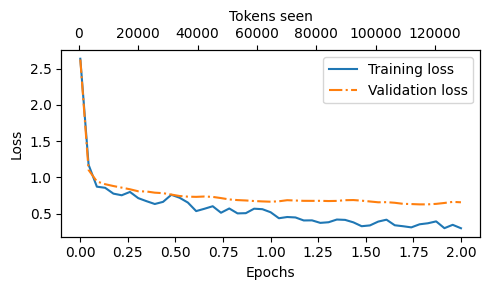

In [30]:
import matplotlib.pyplot as plt
def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax2 = ax1.twiny()  # 创建与 y 轴共用的第二个 x 轴
    ax2.plot(tokens_seen, train_losses, alpha=0)  # 用于对齐刻度的隐藏图形
    ax2.set_xlabel("Tokens seen")
    fig.tight_layout()
    plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

由此生成的损失曲线如图 7.17 所示。

<img src="../Image/chapter7/figure7.17.png" width="75%" />

如图 7.17 的损失图所示，模型在训练集和验证集上的表现随着训练的进行显著提高。在初期阶段，损失的快速下降表明模型正在迅速学习数据中的有意义的模式和表示。随着训练进入第二个 epoch，损失继续减少，但速度放缓，表明模型正在微调其学习到的表示，并逐渐收敛到一个稳定的解。

尽管图 7.17 中的损失曲线表明模型正在有效训练，但最关键的方面是其在响应质量和正确性上的表现。在本章接下来的部分，我们将提取响应，并将其存储为一种便于评估和量化响应质量的格式。

> **练习 7.3 在原始 Alpaca 数据集上进行微调**
>
> 斯坦福大学研究人员创建的 Alpaca 数据集是最早且最受欢迎的公开共享指令数据集之一，包含了 52,002 条数据。作为本章中使用的`instruction-data.json`文件的替代，可以考虑在这个数据集上对 LLM 进行微调。该数据集可通过以下网址获取：https://raw.githubusercontent.com/tatsu-lab/stanford_alpaca/main/alpaca_data.json。
>
> 该数据集包含 52,002 条记录，约为本章使用数据集的 50 倍，且大部分记录的长度也较长。因此，强烈建议使用 GPU 来加速微调过程。如果遇到内存不足错误，可以考虑将批量大小（batch_size）从 8 降至 4、2，甚至 1。此外，降低最大长度（allowed_max_length）从 1024 调整为 512 或 256，也有助于缓解内存问题。

---

## 7.7 提取并保存响应

在之前内容中，我们已经对 LLM 在指令数据集的训练部分进行微调，现在我们开始评估其在测试集上的表现。为此，我们首先对测试集中的每个输入生成模型的回答，并收集这些结果以便人工分析，详见图 7.18。

<img src="../Image/chapter7/figure7.18.png" width="75%" />

我们从步骤 7 开始（详见图 7.18），通过`generate`函数输出模型回答，并将其与预期的前三个测试集答案并排展示，便于进行对比：

In [32]:
torch.manual_seed(123)
# 遍历测试集中的前三个样本
for entry in test_data[:3]:
    input_text = format_input(entry)
    # 使用在第 7.5 节导入的 generate 函数
    token_ids = generate(                  #B
        model=model,
        idx=text_to_token_ids(input_text, tokenizer).to(device),
        max_new_tokens=256,
        context_size=BASE_CONFIG["context_length"],
        eos_id=50256
    )
    generated_text = token_ids_to_text(token_ids, tokenizer)
    response_text = generated_text[len(input_text):].replace("### Response:",
"").strip()

    print(input_text)
    print(f"\nCorrect response:\n>> {entry['output']}")
    print(f"\nModel response:\n>> {response_text.strip()}")
    print("-------------------------------------")

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Rewrite the sentence using a simile.

### Input:
The car is very fast.

Correct response:
>> The car is as fast as lightning.

Model response:
>> The car is as fast as a cheetah.
-------------------------------------
Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
What type of cloud is typically associated with thunderstorms?

Correct response:
>> The type of cloud typically associated with thunderstorms is cumulonimbus.

Model response:
>> A thunderstorm is a thunderstorm that causes extensive surface and regional winds, typically from 20 to 30 miles per hour (40 to 50 kilometers per hour).
-------------------------------------
Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Name the author of 'Pride and Prejudice

如前所述，`generate`函数会返回合并后的输入和输出文本，因此我们可以对 `generated_text` 内容使用切片和 `.replace()` 方法，提取出模型的回复。以下展示了指令、测试集中的预期回复以及模型的实际回复：

从测试集的指令、给定的参考回答以及模型生成的回答来看，模型整体表现相对较好。第一个和最后一个指令的回答明显正确，而第二个回答虽然接近正确，但并非完全准确。模型将‘积云’回答成了‘积雨云’。需要注意的是，积云可以发展成积雨云，而积雨云有可能产生雷暴。

最重要的是，我们可以看到，模型评估并不像上一章那样简单，在上一章中，我们只是通过计算正确的垃圾短信/非垃圾短信标签的百分比来获得分类准确率。而在实际应用中，像聊天机器人这样的指令微调大语言模型（instruction-finetuned LLMs）则需要通过多种方法进行评估：

+ 简答题和多项选择题的基准测试（如 MMLU，"评估大规模多任务语言理解能力"，论文地址：https://arxiv.org/abs/2009.03300），用于测试模型的通用知识水平。
+ 基于人类偏好对其他大语言模型进行比较，例如 LMSYS 的 Chatbot Arena 平台（https://arena.lmsys.org）。
+ 自动化对话基准测试，使用像 GPT-4 这样的 LLM 来评估回答，例如 AlpacaEval（https://tatsulab.github.io/alpaca_eval/）。

在实践中，以上三种评估方法（多项选择题回答、人工评估和自动化指标）都可以选择。然而，我们在本章主要关注对话性能的评估，而不仅仅是回答多选题的能力，因此第二种（人工评估）和第三种（自动化指标）可能更为相关。

人工评估虽然能够提供宝贵的见解，但在处理大量回复时往往耗时费力。例如，阅读并为 1,100 条回复逐一评分将需要投入相当大的精力。

考虑到任务规模，我们将采用类似‘方法3’的方案，通过另一个大语言模型（LLM）对生成的响应进行自动评估。这种方法能够高效地评估响应质量，无需大量的人力参与，从而节省时间和资源，同时仍能获得有意义的性能指标。

在接下来的部分中，我们将借鉴 AlpacaEval 的评估方法，使用另一个 LLM 来评估微调模型的响应。然而，与依赖公开的基准测试数据集不同，我们使用了自定义测试集。这样可以更有针对性地评估模型在实际应用场景中的表现，以反映微调所用指令数据集中所代表的目标任务效果。

为了准备评估过程中需要的响应，我们将生成的模型响应追加到 `test_set` 字典中，并将更新后的数据保存为名为 `instructiondata-with-response.json` 的文件以便记录。此外，保存这个文件后，我们可以在将来的 Python 会话中轻松加载和分析这些响应数据。

以下代码与之前一样使用了 `generate` 方法，但这次模型的响应不再直接打印，而是被添加到 `test_set` 字典中：

In [33]:
# Listing 7.9 Generating test set responses
from tqdm import tqdm

for i, entry in tqdm(enumerate(test_data), total=len(test_data)):
    input_text = format_input(entry)

    token_ids = generate(
        model=model,
        idx=text_to_token_ids(input_text, tokenizer).to(device),
        max_new_tokens=256,
        context_size=BASE_CONFIG["context_length"],
        eos_id=50256
    )
    generated_text = token_ids_to_text(token_ids, tokenizer)
    response_text = generated_text[len(input_text):].replace("### Response:",
"").strip()
    test_data[i]["model_response"] = response_text

with open("../data/instruction-data-with-response.json", "w") as file:
    json.dump(test_data, file, indent=4) # "indent" for pretty-printing

100%|██████████| 110/110 [01:35<00:00,  1.15it/s]


在 A100 GPU 上处理此数据集大约需要 1 分钟，而在 M3 MacBook Air 上则需要约 6 分钟。

我们来验证一下响应是否已正确添加到测试集字典中，可以通过检查其中一个条目来实现：

In [34]:
print(test_data[0])

{'instruction': 'Rewrite the sentence using a simile.', 'input': 'The car is very fast.', 'output': 'The car is as fast as lightning.', 'model_response': 'The car is as fast as a cheetah.'}


最后，我们将模型保存为文件 gpt2-medium355M-sft.pth，以便在未来的项目中复用：

In [35]:
import re

# Remove white spaces and parentheses from file name
file_name = f"{re.sub(r'[ ()]', '', CHOOSE_MODEL) }-sft.pth"
torch.save(model.state_dict(), file_name)
print(f"Model saved as {file_name}")

Model saved as gpt2-medium355M-sft.pth


---

## 7.8 评估指令微调后的 LLM

之前章节中，我们通过查看模型在测试集中的 3 个示例上的响应来评估指令微调模型的性能。虽然这种方法可以提供模型表现的大致概况，但不适合用于大规模响应的评估。因此，我们在本节中实现了一种新方法（如图 7.19 的章节概览所示），利用另一个更大的大语言模型对微调模型的响应进行自动化评估。

<img src="../Image/chapter7/figure7.19.png" width="75%" />

为了实现图 7.19 中第 9 步（以自动化方式评估测试集响应），我们使用了 Meta AI 开发的一个经过指令微调的 Llama 3 模型，该模型拥有 80 亿参数，可以通过开源应用程序 Ollama 在本地运行（官网：[https://ollama.com](https://ollama.com)）。

Ollama 是一个高效的应用程序，适用于在笔记本电脑上运行大语言模型（LLM）。它是开源库 `llama.cpp`（[https://github.com/ggerganov/llama.cpp](https://github.com/ggerganov/llama.cpp)）的封装，该库用纯 C/C++ 实现了 LLM，旨在最大化效率。然而，需要注意的是，Ollama 仅用于使用 LLM 生成文本（推理），并不支持训练或微调 LLM。

> [!NOTE]
>
> **通过Web API使用更强大的 LLM**
>
> 拥有 80 亿参数的 Llama 3 模型是一款性能非常强大的 LLM，能够在本地运行。然而，与 OpenAI 提供的 GPT-4 等商业化大模型相比，Llama 3 的能力稍显不足。如果读者感兴趣，可以通过 OpenAI 的 API 使用 GPT-4 来评估生成的模型响应。相关代码笔记本已作为本书的补充材料提供，读者可访问以下 GitHub 链接获取更多信息：
> https://github.com/rasbt/LLMs-from-scratch/blob/main/ch07/03_model-evaluation/llm-instruction-eval-openai.ipynb

为运行以下代码，请访问 https://ollama.com 并根据您的操作系统说明安装 Ollama：

+ 针对 macOS 和 Windows 用户：打开已下载的 Ollama 应用。如果提示安装命令行工具，请选择‘是’。
+ 针对 Linux 用户：请使用 Ollama 网站提供的安装命令。

在实现模型评估代码之前，我们需要先下载 Llama 3 模型，并通过命令行验证 Ollama 是否正常运行。

<img src="../Image/chapter7/figure7.20.png" width="75%" />

如图 7.20 所示，在另一终端中运行 Ollama 应用程序或 Ollama 服务后，请在命令行（不是在 Python 会话中）执行以下命令来运行具有 80 亿参数的 Llama 3 模型：

In [ ]:
ollama run llama3

首次执行该命令时， Llama 3 模型（占用 4.7 GB 存储空间）将会自动下载。下载后的输出如下所示：

In [ ]:
pulling manifest
pulling 6a0746a1ec1a... 100% ▕████████████████▏ 4.7 GB
pulling 4fa551d4f938... 100% ▕████████████████▏ 12 KB
pulling 8ab4849b038c... 100% ▕████████████████▏ 254 B
pulling 577073ffcc6c... 100% ▕████████████████▏ 110 B
pulling 3f8eb4da87fa... 100% ▕████████████████▏ 485 B
verifying sha256 digest
writing manifest
removing any unused layers
success

> [!NOTE]
>
> **Ollama 模型的替代方案**
>
> 需要注意的是，`ollama run llama3` 命令中的 `llama3` 指的是一个经过指令微调的 Llama 3 模型，具有 80 亿参数。运行 `llama3` 模型时，大约需要 16 GB 的内存。如果设备内存不足，建议尝试更小的模型，例如参数量为 38 亿的 `phi-3` 模型，该模型通过 `ollama run llama3` 命令加载，仅需约 8 GB 内存即可运行。
>
> 对于高性能计算机，你可以选择更大的 Llama 3 模型（700 亿参数版本），只需将 `llama3` 替换为 `llama3:70b`。但请注意，该模型对计算资源的需求会显著增加。

当模型下载完成后，系统会显示一个命令行界面，用来与模型进行交互。例如，你可以试着向模型提问：“What do llamas eat?“

In [36]:
>>> What do llamas eat?
Llamas are ruminant animals, which means they have a four-chambered
stomach and eat plants that are high in fiber. In the wild, llamas
typically feed on:
1. Grasses: They love to graze on various types of grasses, including tall
grasses, wheat, oats, and barley.

SyntaxError: invalid syntax (2070251980.py, line 2)

需要注意的是，Ollama 模型在当前版本中具有非确定性，因此你看到的响应可能会有所不同。

你可以通过输入 `/bye` 来结束当前的 ollama run llama3 会话。但请确保在本章剩余内容中，后台的 ollama serve 命令或 Ollama 应用程序继续保持运行。

以下代码用于验证 Ollama 会话是否正常运行，以便在评估上一节生成的测试集响应之前确保其可用性：

In [ ]:
import psutil

def check_if_running(process_name):
    running = False
    for proc in psutil.process_iter(["name"]):
        if process_name in proc.info["name"]:
            running = True
            break
    return running

ollama_running = check_if_running("ollama")

if not ollama_running:
    raise RuntimeError("Ollama not running. Launch ollama before proceeding.")
print("Ollama running:", check_if_running("ollama"))

请确保执行以上代码的输出结果为 “Ollama running: True”。如果显示为 False，请检查是否已正确运行 `ollama serve` 命令或 Ollama 应用程序。

> [!NOTE]
>
> **在一个新的 Python 会话中运行代码**
>
> 如果你在第 7.7 节后关闭了 Python 会话，或者希望在新的会话中运行本章后续代码，可以执行以下代码。这些代码将加载我们在第 7.7 节中创建的指令和响应数据文件，同时重新定义之前使用的 `format_input` 函数（后续代码中还会使用 `tqdm` 进度条工具）。

In [ ]:
import json
from tqdm import tqdm

file_path = "instruction-data-with-response.json"
with open(file_path, "r") as file:
    test_data = json.load(file)

def format_input(entry):
    instruction_text = (
        f"Below is an instruction that describes a task. "
        f"Write a response that appropriately completes the request."
        f"\n\n### Instruction:\n{entry['instruction']}"
    )

    input_text = f"\n\n### Input:\n{entry['input']}" if entry["input"] else ""
    return instruction_text + input_text

一种替代 `ollama run` 命令与模型交互的方法是通过 Python 使用其 REST API。以下 `query_model` 函数示例演示了如何使用该 API：

In [ ]:
# Listing 7.10 Querying a local Ollama model
import urllib.request

def query_model(prompt, model="llama3", url="http://localhost:11434/api/chat"):
    data = {                                                               #A
        "model": model,
        "seed": 123, # for deterministic responses
        "temperature": 0, # for deterministic responses
        "messages": [
            {"role": "user", "content": prompt}
        ]
    }

    payload = json.dumps(data).encode("utf-8")                             #B
    request = urllib.request.Request(url, data=payload, method="POST")     #C
    request.add_header("Content-Type", "application/json")                 #C

    response_data = ""
    with urllib.request.urlopen(request) as response:                      #D
        while True:
            line = response.readline().decode("utf-8")
            if not line:
                break
            response_json = json.loads(line)
            response_data += response_json["message"]["content"]
    return response_data


#A 将数据载荷创建为字典格式
#B 将字典转换为 JSON 格式字符串，并编码为字节数据
#C 创建请求对象，设置方法为 POST，并添加必要的请求头
#D 发送请求并接收响应

考虑到每个学习者的使用电脑配置不同，这里使用 DeepSeek 的 API 来查询模型。

In [39]:
from openai import OpenAI

client = OpenAI(api_key="xxxxxxx", base_url="https://api.deepseek.com")

def query_model(prompt):
    response = client.chat.completions.create(
        model="deepseek-chat",
        messages=[
            {"role": "system", "content": "You are a helpful assistant"},
            {"role": "user", "content": prompt},
        ],
        stream=False
    )

    return response.choices[0].message.content

在执行后续代码之前，请确保 Ollama 服务仍在运行。之前的代码应输出‘Ollama running: True’，以确保模型已启动并可以接收请求。

接下来，我们通过以下示例说明如何使用刚实现的 `query_llama` 函数:

In [41]:
model = "llama3"
result = query_model("What do Llamas eat?")
print(result)

Llamas are herbivores and primarily eat grasses, hay, and other plant materials. Their diet typically includes:

1. **Grass and Hay** – The bulk of their diet consists of fresh grass or high-quality hay (such as timothy, alfalfa, or orchard grass).  
2. **Grains and Pellets** – In moderation, they can eat fortified llama or alpaca pellets for extra nutrients.  
3. **Vegetables and Fruits** – Occasionally, they enjoy treats like carrots, apples, or leafy greens (but avoid excessive sugar).  
4. **Mineral Supplements** – Llamas need access to salt licks or mineral blocks to maintain proper nutrient levels.  

They have efficient digestive systems (similar to cows and sheep) and chew cud to break down tough plant fibers. Avoid overfeeding grains or sugary foods, as this can cause digestive issues.  

If you're caring for llamas, ensure they have clean water, good-quality forage, and a balanced diet tailored to their age and activity level.


了解了 `query_model` 函数的用法，我们现在可以通过一个`prompt`来评估微调模型的响应质量。具体来说，`prompt`要求 Llama 3 模型根据测试集中的参考响应，对微调模型的响应进行 0 到 100 的评分。

首先，我们将这种方法用于测试集的前三个样本，这些样本已在前文中分析过：

In [42]:
for entry in test_data[:3]:
    prompt = (
        f"Given the input `{format_input(entry)}` "
        f"and correct output `{entry['output']}`, "
        f"score the model response `{entry['model_response']}`"
        f" on a scale from 0 to 100, where 100 is the best score. "
    )
    print("\nDataset response:")
    print(">>", entry['output'])
    print("\nModel response:")
    print(">>", entry["model_response"])
    print("\nScore:")
    print(">>", query_model(prompt))
    print("\n-------------------------")


Dataset response:
>> The car is as fast as lightning.

Model response:
>> The car is as fast as a cheetah.

Score:
>> The model response "The car is as fast as a cheetah." is a well-constructed simile that effectively conveys the speed of the car. 

Here's the scoring breakdown:
- **Accuracy**: The simile is accurate and makes logical sense (cheetahs are known for their speed). (30/30)
- **Creativity**: While cheetahs are a common metaphor for speed, the response is still creative and appropriate. (25/25)
- **Clarity**: The sentence is clear and easy to understand. (25/25)
- **Relevance**: The simile is highly relevant to the original sentence. (20/20)

**Total Score: 100/100**  

The response is excellent and fully meets the criteria for a good simile. While "lightning" is also a great simile, "cheetah" is equally valid and vivid.

-------------------------

Dataset response:
>> The type of cloud typically associated with thunderstorms is cumulonimbus.

Model response:
>> The type of

这将打印出类似于以下的输出（请注意，截至本文写作时，Ollama 不是完全确定性的，因此生成的文本可能会有所不同）：

通过生成的回答可以看出，Llama 3 模型具有合理的评估能力，即使答案不完全正确，也能够给予部分分数。例如，在对“cumulus cloud”这一回答的评估中，模型能够识别答案中的部分正确性，并对此作出相应评价。

以上的`promp返回的不仅有评分，还包括高度详细的评价内容。我们可以修改`prompt`，使其只生成 0 到 100 的整数评分（其中 100 表示最高分）。这样一来，我们就可以计算模型的平均分，将其作为对模型性能更简洁且量化的评估。

下面的 `generate_model_scores` 函数使用了一个修改后的`prompt`，要求模型‘仅回复整数’：

In [44]:
# Listing 7.11 Evaluating the instruction finetuning LLM
def generate_model_scores(json_data, json_key):
    scores = []
    for entry in tqdm(json_data, desc="Scoring entries"):
        prompt = (
            f"Given the input `{format_input(entry)}` "
            f"and correct output `{entry['output']}`, "
            f"score the model response `{entry[json_key]}`"
            f" on a scale from 0 to 100, where 100 is the best score. "
            f"Respond with the integer number only."  # 修改后的指令设置为仅返回分数
        )
        score = query_model(prompt)
        try:
            scores.append(int(score))
        except ValueError:
            print(f"Could not convert score: {score}")
            continue

    return scores

In [45]:
# Let's now apply the generate_model_scores function to the entire test_data set, which takes about 1 minute on a M3 Macbook Air:
scores = generate_model_scores(test_data, "model_response")
print(f"Number of scores: {len(scores)} of {len(test_data)}")
print(f"Average score: {sum(scores)/len(scores):.2f}\n")

Scoring entries: 100%|██████████| 110/110 [07:40<00:00,  4.19s/it]

Number of scores: 110 of 110
Average score: 39.91



评估结果显示，我们的微调模型平均得分为 40 分，这为与其他模型进行对比提供了一个有用的基准，同时也可以基于该基准尝试不同的训练配置，以进一步提升模型的性能。

需要注意的是，撰写本文时，Ollama 的结果并非完全固定，这意味着您得到的分数可能会与上述结果略有不同。为了获得更稳定的结果，可以重复多次评估，并取平均值。

为了提升模型性能，我们可探索多种策略，例如：

+	在微调阶段，可以通过调整超参数（如学习率、批次大小和训练轮数）来优化模型性能。
+	通过扩大训练数据集规模或丰富样本的多样性，以覆盖更广泛的主题和风格。
+	尝试不同的提示或指令格式，以更有效地引导模型的回答。
+	考虑使用更大的预训练模型，这类模型可能具有更强的能力，能够捕捉复杂模式并生成更准确的响应。

> [!NOTE]
>
> **LLaMA 3 模型性能**
>
> 作为参考，使用本节描述的方法，Llama 3 8B 基础模型（未经过任何微调）在测试集上的平均得分为 58.51。而经过在通用指令遵循数据集上微调的 Llama 3 8B 指令模型，在测试集上的平均得分高达 82.6，表现相当出色。

> [!NOTE]
>
> **练习 7.4：使用 LoRA 实现参数高效微调**
>
> 为了更高效地对 LLM 进行指令微调，请修改本章的代码，采用附录 E 中的 LoRA 方法。然后，对比修改前后训练时长和模型性能。

---

## 7.9 结语

本章总结了大语言模型（LLM）开发流程的关键步骤，包括实现 LLM 架构、预训练模型以及针对特定任务的微调，具体内容可参考图 7.21。

<img src="../Image/chapter7/figure7.21.png" width="75%" />

接下来的小节将为你提供一些思路，帮助你在完成图 7.21 中展示的关键步骤后，进一步探索下去。



### 7.9.1 接下来如何做？

尽管我们已经讲解了模型训练的核心步骤（详见图 7.21），但在完成指令微调后，还可以选择进行偏好微调（Preference Finetuning）。偏好微调对于定制模型以更好地符合特定用户的需求尤为有用。如果您希望进一步了解这一过程，可以参考书籍补充资源中的 GitHub 仓库（[链接](https://github.com/rasbt/LLMs-from-scratch/tree/main/ch07/04_preference-tuning-withdpo)），查看 `04_preference-tuning-with-dpo` 文件夹。

除了书中涵盖的主要内容外，GitHub 仓库还提供了丰富的额外材料，这些内容可能对您非常有价值。如需了解更多，请访问仓库 README 页面的“Bonus Material”部分：https://github.com/rasbt/LLMs-from-scratch?tab=readme-ov-file#bonus-material。



### 7.9.2 如何在快速变化的前沿领域中保持领先

人工智能和大语言模型的研究领域正在迅速发展（许多人可能觉得这非常令人兴奋）。想要了解最新进展，可以浏览 arXiv 上的最新研究论文（网址：[https://arxiv.org/list/cs.LG/recent](https://arxiv.org/list/cs.LG/recent)）。此外，许多研究人员和从业者也会在社交媒体平台（如 X（原 Twitter）和 Reddit）上积极分享和讨论最新动态。尤其是 Reddit 的 r/LocalLLaMA 版块，是了解社区动态以及最新工具和趋势的好资源。

我会定期在博客上分享关于大语言模型（LLM）研究的最新动态和见解，您可以通过以下地址访问：https://magazine.sebastianraschka.com 和 https://sebastianraschka.com/blog/。

感谢你一路同行，祝愿你在未来的大语言模型和人工智能领域的探索中一切顺利！

---

## 7.10 本章摘要

+ 指令微调的过程旨在将预训练的大语言模型调整为能够遵循人类指令并生成预期回答。
+ 准备数据集需要下载指令-响应数据集，对数据进行格式化，并划分为训练集、验证集和测试集。
+ 自定义的`collate`函数用于构建训练批次，处理过程包括对序列数据进行填充，生成目标 token 的 ID，并对填充的 token 进行掩码处理。
+ 我们加载了一个具有 3.55 亿参数的预训练 GPT-2 medium 模型，作为指令微调的起点。
+ 预训练模型在指令数据集上进行了微调，训练方式类似于预训练的循环。
+ 评估涉及在测试集上提取模型响应并对其进行评分，例如，使用另一个LLM进行评分。
+ Ollama 应用利用一个 80 亿参数的 Llama 模型，可以对微调模型在测试集上的响应进行自动评分，并通过平均分来量化模型的性能表现。